In a recent project I was facing the task of running machine learning on about 100 TB of data. This amount of data was exceeding the capacity of my workstation, so I translated the code from running on scikit-learn to Apache Spark using the PySpark API. This allowed me to process that data using in-memory distributed computing.

This blog post is written as an introduction to machine learning on Spark, based on this recent project.

# Installation

The instructions in this section refer to a local installation on a single machine. While that does not make much sense in a production environment, it is good for trying things out and for a demonstration like I do in this blog post. 

Start by heading over to http://spark.apache.org/downloads.html and download a version of your choice prebuilt Hadoop. For the KMeans algorithm we are going to demonstrate today, there are some changes between Spark 1.6.x and 2.x, so not all lines in this demo will work if you choose to work with the older version.

Once downloaded and unpacked, you can move it to /opt and set a symbolic link to your new version (assuming that you are using a linux operating system).

```
sudo mv spark-2.1.1-bin-hadoop2.7 /opt/spark-2.1.1
sudo ln -s /opt/spark-2.1.1 /opt/spark
```

By adding the following lines to your .bashrc you will make the pyspark classes available to your python installation, and you will be able to start a new pyspark enabled jupyter notebook by simply typing _pyspark_ from a command line.

```
# Spark
export SPARK_HOME=/opt/spark
export PATH=$SPARK_HOME/bin:$PATH
export PYSPARK_DRIVER_PYTHON=jupyter
export PYSPARK_DRIVER_PYTHON_OPTS='notebook'
# Add the PySpark classes to the Python path:
export PYTHONPATH=$SPARK_HOME/python/:$PYTHONPATH
```

# Getting started

You should now have a new jupyter notebook in front of you. First we import some things we will need later.

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

%matplotlib inline

print (pyspark.__version__)

2.1.1+hadoop2.7


# Generate some input data

We also want to have some data to work with. A simple way to get that is to generate it using scikit-learn's method to generate ten blobs in a three-dimensional space. 

To make it more realistic we also add an 'id' column of strings, which in real life is often the customer id or the IP address of the IoT device, or similar.

Last we write the dataset as a CSV file, which despite being an awful format, is the one I encounter every day.

In [2]:
n_samples=10000
n_features=3
X, y = make_blobs(n_samples=n_samples, centers=10, n_features=n_features, random_state=42)

# add a row index as a string
pddf = pd.DataFrame(X, columns=['x', 'y', 'z'])
pddf['id'] = 'row'+pddf.index.astype(str)

#move it first (left)
cols = list(pddf)
cols.insert(0, cols.pop(cols.index('id')))
pddf = pddf.ix[:, cols]
pddf.head()

# save the ndarray as a csv file
pddf.to_csv('input.csv', index=False)

This is a visualization of the data we just generated, where the true type of each data point is represented by a unique color.

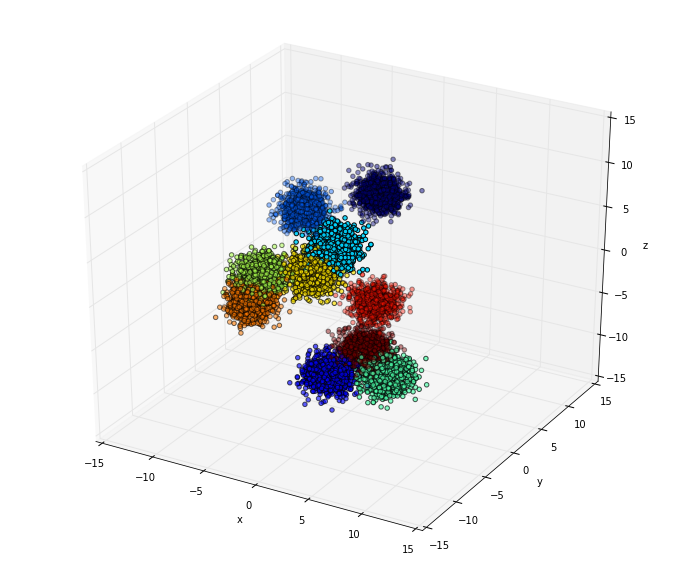

In [3]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(X[:,0], X[:,1], X[:,2], c=y)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

# SQL context

The SparkContext is created by default with the variable name _sc_ with the way we started the spark enabled notebook. We do, however, want to create an SQLContext. According to the Spark documentation https://spark.apache.org/docs/latest/sql-programming-guide.html :

_"Spark SQL is a Spark module for structured data processing. Unlike the basic Spark RDD API, the interfaces provided by Spark SQL provide Spark with more information about the structure of both the data and the computation being performed."_

What this means is that we can use Spark dataframes, which are similar to Pandas dataframes, and is a dataset organized into named columns.

In [4]:
#sc = SparkContext(appName="PythonKMeansExample") # exist by default
sqlContext = SQLContext(sc)

# Read in data from CSV into a Spark data frame

The data contains four columns, 'id', 'x', 'y', 'z', and it is the latter three that we want to use as features in our clustering model.

In [5]:
FEATURES_COL = ['x', 'y', 'z']
path = 'input.csv'

If you are using a recent Spark version, reading in the CSV file can be done in a single line:

In [6]:
df = sqlContext.read.csv(path, header=True) # requires spark 2.0
df.show()

+-----+----------------+--------------+---------------+
|   id|               x|             y|              z|
+-----+----------------+--------------+---------------+
| row0|  -6.07769967697|-2.90961030573| -1.51817288652|
| row1|  -1.01226004892| 7.32284130418| -5.44240743043|
| row2|  -8.29700646263| 6.32289354302|  1.16720476045|
| row3|  -3.50712145606| 4.78481175171| -5.44494747292|
| row4|  -5.12282340492|-3.32204974145|-0.506980471989|
| row5|  -2.47640062764|  8.2557907935|  4.40947812202|
| row6|   7.31539534799| -5.0794489521| -7.29121494814|
| row7|  -2.01674635904| 9.30345477211|  7.09517897614|
| row8| -0.233818503726|-4.89268110188|  2.12288762669|
| row9|   6.56544208126|-6.85599416025| -6.79832126872|
|row10|  -5.69028457049|-6.48274025874|-0.924696680813|
|row11|-0.0179861427066| 2.76323663977| -8.81482452874|
|row12|  -6.90426251621|-6.14917209412| -3.53542949201|
|row13|  -10.3898651776| 9.53785285806| 0.674591004555|
|row14|   3.96886833004|-6.04678462303|  -5.4623

If using earlier version it is possible to achieve the same result like this:

In [7]:
lines = sc.textFile(path)
data = lines.map(lambda line: line.split(","))
data.take(2)

[[u'id', u'x', u'y', u'z'],
 [u'row0', u'-6.07769967697', u'-2.90961030573', u'-1.51817288652']]

Notice that the table header is included as the first row. We ignore that for now and convert _data_ to a Spark dataframe.

In [8]:
df = data.toDF(['id', 'x', 'y', 'z'])
print (df)
df.show()

DataFrame[id: string, x: string, y: string, z: string]
+-----+----------------+--------------+---------------+
|   id|               x|             y|              z|
+-----+----------------+--------------+---------------+
|   id|               x|             y|              z|
| row0|  -6.07769967697|-2.90961030573| -1.51817288652|
| row1|  -1.01226004892| 7.32284130418| -5.44240743043|
| row2|  -8.29700646263| 6.32289354302|  1.16720476045|
| row3|  -3.50712145606| 4.78481175171| -5.44494747292|
| row4|  -5.12282340492|-3.32204974145|-0.506980471989|
| row5|  -2.47640062764|  8.2557907935|  4.40947812202|
| row6|   7.31539534799| -5.0794489521| -7.29121494814|
| row7|  -2.01674635904| 9.30345477211|  7.09517897614|
| row8| -0.233818503726|-4.89268110188|  2.12288762669|
| row9|   6.56544208126|-6.85599416025| -6.79832126872|
|row10|  -5.69028457049|-6.48274025874|-0.924696680813|
|row11|-0.0179861427066| 2.76323663977| -8.81482452874|
|row12|  -6.90426251621|-6.14917209412| -3.535429

# Convert all data columns to float

The dataframe consists now of four columns of strings. The machine learning model needs the data to be numbers so we must convert the features to floats.

Converting all data to float is possible in a single line. However this would make the 'id' column filled with null, or we would have to omit it:

In [9]:
df_feat = df.select(*(df[c].cast("float").alias(c) for c in df.columns[1:]))
df_feat.show()

+------------+----------+----------+
|           x|         y|         z|
+------------+----------+----------+
|        null|      null|      null|
|  -6.0776997|-2.9096103|-1.5181729|
|  -1.0122601|  7.322841|-5.4424076|
|   -8.297007| 6.3228936| 1.1672047|
|  -3.5071216|  4.784812|-5.4449472|
|   -5.122823|-3.3220499|-0.5069805|
|  -2.4764006|  8.255791|  4.409478|
|   7.3153954| -5.079449| -7.291215|
|  -2.0167463|  9.303454|  7.095179|
|  -0.2338185| -4.892681| 2.1228876|
|    6.565442| -6.855994|-6.7983212|
|  -5.6902847|-6.4827404|-0.9246967|
|-0.017986143| 2.7632365| -8.814824|
|  -6.9042625|-6.1491723|-3.5354295|
|  -10.389865|  9.537853|  0.674591|
|   3.9688683|-6.0467844| -5.462389|
|   -7.337052|-3.7689247| -5.261122|
|   -8.991589|  8.738728|  3.864116|
| -0.18098584|  5.482743| -4.900118|
|   3.3193955|-6.3573766| -6.978025|
+------------+----------+----------+
only showing top 20 rows



Since we know which columns need to be converted, we get a cleaner result by converting those one by one.

In [10]:
for col in df.columns:
    if col in FEATURES_COL:
        df = df.withColumn(col,df[col].cast('float'))
df.show()

+-----+------------+----------+----------+
|   id|           x|         y|         z|
+-----+------------+----------+----------+
|   id|        null|      null|      null|
| row0|  -6.0776997|-2.9096103|-1.5181729|
| row1|  -1.0122601|  7.322841|-5.4424076|
| row2|   -8.297007| 6.3228936| 1.1672047|
| row3|  -3.5071216|  4.784812|-5.4449472|
| row4|   -5.122823|-3.3220499|-0.5069805|
| row5|  -2.4764006|  8.255791|  4.409478|
| row6|   7.3153954| -5.079449| -7.291215|
| row7|  -2.0167463|  9.303454|  7.095179|
| row8|  -0.2338185| -4.892681| 2.1228876|
| row9|    6.565442| -6.855994|-6.7983212|
|row10|  -5.6902847|-6.4827404|-0.9246967|
|row11|-0.017986143| 2.7632365| -8.814824|
|row12|  -6.9042625|-6.1491723|-3.5354295|
|row13|  -10.389865|  9.537853|  0.674591|
|row14|   3.9688683|-6.0467844| -5.462389|
|row15|   -7.337052|-3.7689247| -5.261122|
|row16|   -8.991589|  8.738728|  3.864116|
|row17| -0.18098584|  5.482743| -4.900118|
|row18|   3.3193955|-6.3573766| -6.978025|
+-----+----

# Drop the null values

Due to the extra inclusion of the header row as the first row in the dataframe, that row is now filled with null values. Let's drop that row, and any other row that could contain null values.

In [11]:
df = df.na.drop()
df.show()

+-----+------------+----------+----------+
|   id|           x|         y|         z|
+-----+------------+----------+----------+
| row0|  -6.0776997|-2.9096103|-1.5181729|
| row1|  -1.0122601|  7.322841|-5.4424076|
| row2|   -8.297007| 6.3228936| 1.1672047|
| row3|  -3.5071216|  4.784812|-5.4449472|
| row4|   -5.122823|-3.3220499|-0.5069805|
| row5|  -2.4764006|  8.255791|  4.409478|
| row6|   7.3153954| -5.079449| -7.291215|
| row7|  -2.0167463|  9.303454|  7.095179|
| row8|  -0.2338185| -4.892681| 2.1228876|
| row9|    6.565442| -6.855994|-6.7983212|
|row10|  -5.6902847|-6.4827404|-0.9246967|
|row11|-0.017986143| 2.7632365| -8.814824|
|row12|  -6.9042625|-6.1491723|-3.5354295|
|row13|  -10.389865|  9.537853|  0.674591|
|row14|   3.9688683|-6.0467844| -5.462389|
|row15|   -7.337052|-3.7689247| -5.261122|
|row16|   -8.991589|  8.738728|  3.864116|
|row17| -0.18098584|  5.482743| -4.900118|
|row18|   3.3193955|-6.3573766| -6.978025|
|row19|  -2.0266335|-3.4171724|0.48218703|
+-----+----

# Create a features column to be used in the clustering

Spark's implementation of KMeans is a bit different from for example scikit-learn's version. We need to store all features as an array of floats, and store this array as a column called "features". Since we do no longer need the original columns we filter them out with a _select_ statement.

In [12]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df).select('id', 'features')
df_kmeans.show()

+-----+--------------------+
|   id|            features|
+-----+--------------------+
| row0|[-6.0776996612548...|
| row1|[-1.0122600793838...|
| row2|[-8.2970066070556...|
| row3|[-3.5071215629577...|
| row4|[-5.1228232383728...|
| row5|[-2.4764006137847...|
| row6|[7.31539535522460...|
| row7|[-2.0167462825775...|
| row8|[-0.2338185012340...|
| row9|[6.56544208526611...|
|row10|[-5.6902847290039...|
|row11|[-0.0179861430078...|
|row12|[-6.9042625427246...|
|row13|[-10.389864921569...|
|row14|[3.96886825561523...|
|row15|[-7.3370518684387...|
|row16|[-8.9915885925292...|
|row17|[-0.1809858381748...|
|row18|[3.31939554214477...|
|row19|[-2.0266335010528...|
+-----+--------------------+
only showing top 20 rows



# Optimize choice of k

One disadvantage of KMeans compared to more advanced clustering algorithms is that the algorithm must be told how many clusters, _k_, it should try to find. To optimize _k_ we cluster a fraction of the data for different choices of _k_ and look for an "elbow" in the cost function.

In [13]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) # requires Spark 2.0 or later

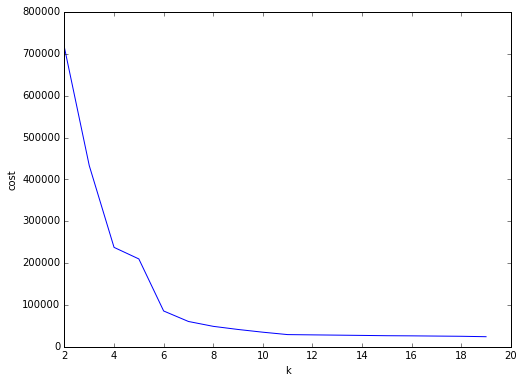

In [14]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

Look like there is very little gain after _k_=10, so we stick to that choice when processing the full data set.

# Train the machine learning model

We are now ready to train the model on the full dataset. While this is running, you might want to open http://localhost:4040 where details about the job is shown.

Once the training has converged we can print out the centroids of the ten clusters.

In [15]:
k = 10
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[-0.90157747  5.71691605 -5.97326952]
[ 4.11111715 -9.61155031  9.41405178]
[-6.79412744 -4.03698923 -1.10068529]
[ 6.64357607 -5.69151668 -6.26962695]
[-2.46074836  9.0641161   4.6330292 ]
[-1.37310198 -4.21769187  2.22783021]
[ 0.27991887  1.81322325 -9.14288007]
[ 1.58888263 -7.41096821 -6.41331828]
[-8.79877678  7.30752724  2.00242494]
[ 2.48626915 -6.42431818 -7.47402925]


# Assign clusters to events

Their is one import thing left to do; assigning the individual rows to the nearest cluster centroid. That can be done with the _transform_ method, which adds 'prediction' column to the dataframe. The prediction value is an integer between 0 and _k_, but it has no correlation to the _y_ value of the input.

In [16]:
transformed = model.transform(df_kmeans).select('id', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(id=u'row0', prediction=2), Row(id=u'row1', prediction=0), Row(id=u'row2', prediction=8)]


From the rows returned by the collect method it is trivial to create a new dataframe using our SQL context.

In [17]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

+-----+----------+
|   id|prediction|
+-----+----------+
| row0|         2|
| row1|         0|
| row2|         8|
| row3|         0|
| row4|         2|
| row5|         4|
| row6|         3|
| row7|         4|
| row8|         5|
| row9|         3|
|row10|         2|
|row11|         6|
|row12|         2|
|row13|         8|
|row14|         9|
|row15|         2|
|row16|         8|
|row17|         0|
|row18|         9|
|row19|         5|
+-----+----------+
only showing top 20 rows



# Join the prediction with the original data

The _x_, _y_, _z_ from the original dataframe can be added to the newly created dataframe by joining the two dataframes on the 'id' column.

In [18]:
df_pred = df_pred.join(df, 'id')
df_pred.show()

+-------+----------+----------+----------+----------+
|     id|prediction|         x|         y|         z|
+-------+----------+----------+----------+----------+
|row1093|         8| -7.601147|  7.069047|  1.564275|
|row1099|         5|-0.7107884|-3.3169584|  2.488001|
| row119|         2| -9.524287| -5.396073|-3.3982348|
|row1191|         6|-0.8568603|  2.037963|-10.700185|
|row1352|         0| -1.669029|  6.943214|-6.0198708|
|row1586|         3|  8.243615|-6.7687254| -6.591385|
|row1766|         1| 3.5482397|  -9.91293|  9.635929|
|row2684|         0|-0.5487077|    6.2472|-4.9076533|
|row2770|         4|-2.4884038| 8.2862835| 4.4569826|
|row2883|         3|  7.196379|-5.0276275| -4.923547|
|row3313|         0|-1.3719763| 4.7211256|-5.1501107|
| row332|         8|-7.6491013|  7.990768| 1.9940823|
|row3374|         6| 1.9008663| 2.4249678| -8.085093|
|row3376|         2|  -5.62288|-2.5612633|0.39997813|
|row4049|         5|-1.7804127|-4.6741023| 2.5568235|
|row4152|         8| -9.1510

# Convert to Pandas dataframe

Typically at this point I would need to do something else with the data, which does not require Spark, so let's convert the Spark dataframe to a good old Pandas dataframe for further processing.

In [19]:
pddf_pred = df_pred.toPandas().set_index('id')
pddf_pred.head()

,prediction,x,y,z
id,,,,
row1093,8,-7.601147,7.069047,1.564275
row1099,5,-0.710788,-3.316958,2.488001
row119,2,-9.524287,-5.396073,-3.398235
row1191,6,-0.856860,2.037963,-10.700185
row1352,0,-1.669029,6.943214,-6.019871


# Visualize the results

The final step is to visually inspect the output to see if the KMeans model did a good job or not. Comparing with the first figure it is clear that most clusters were indeed found, but the left blue cluster should have been split in two and the orange+brown clusters should have been only one cluster.

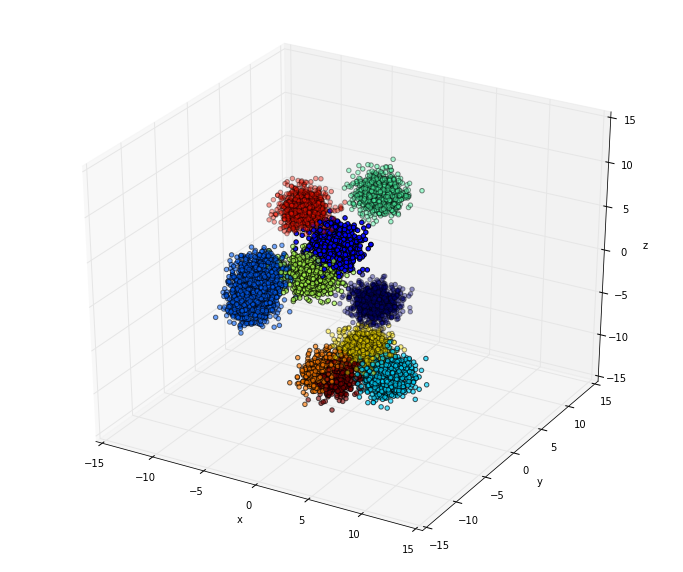

In [20]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.x, pddf_pred.y, pddf_pred.z, c=pddf_pred.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

If done with Spark, we can now shut down the Spark context:

In [21]:
sc.stop()

# Conclusion

This blog post has demonstrated how to install Spark on a local machine and run a simple clustering algorithm using Spark. Your next step could be to power up a Spark cluster on Microsoft Azure HDInsight, or on Amazon AWS EMR. Or, if you rather run experiments locally, you could buy lots of Raspberry Pi's for a modest sum. The Raspberry Pi is too weak and does not have enough memory for real life workloads, but it is a good way to get practical experience.

If you have comments, questions or corrections, please add them to the comment section below.